**Author:** [Martina Cinquini](http://pages.di.unipi.it/cinquini/)  
**Python version:**  3.8 <br>
**Last update:** 12/02/21

# GENCDA - GEnerative Nonlinear Causal Discovery with Apriori 

### Overview<a class="anchor" id="section1"></a>

We present **GENCDA, a synthetic data GEnerator based on NCDA.** This method exploits the causal relationships discovered by NCDA to generate a synthetic dataset respecting such causal structure.

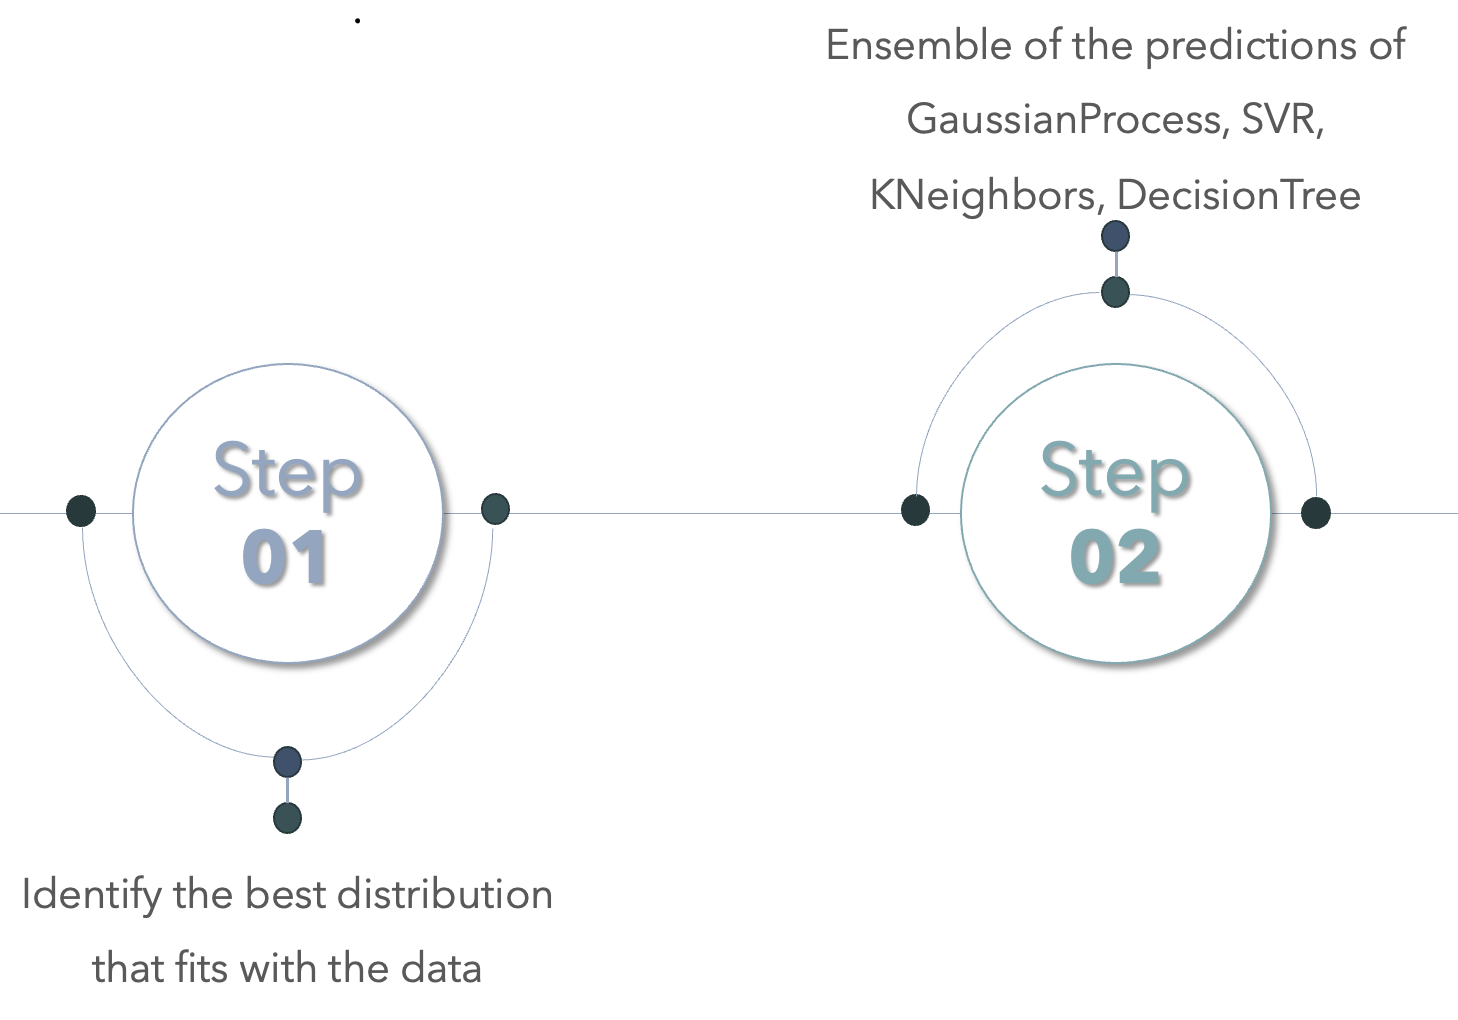

In [1]:
%matplotlib inline
import pandas as pd
import os
from sklearn import datasets
import matplotlib.pyplot as plt
import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

from utils import * 
from causalDataframe import *
from causal_discovery.ncda import * 
from data_generation.randomDataframe import *
from data_generation.relatedDataframe import * 
from data_generation.evaluation.kde import *
from data_generation.evaluation.lof import *
from sdv.tabular import CTGAN
from sdv.tabular import TVAE

In [2]:
path = '/Users/martina/Desktop/'

# DATASETS

**1# Option**: From sklearn

In [3]:
"""
A possible Ground Truth 

['bmi' --> 'si', 'bmi' --> 'bp', 'si' --> 'bp']

"""

diabetes = datasets.load_diabetes()
dataframe = diabetes['data'][:, [0, 1, 2, 3, 4]]
data = pd.DataFrame(dataframe, columns=['age', 'sex', 'bmi', 'bp', 'si'])
data.head()

,age,sex,bmi,bp,si
0,0.038076,0.050680,0.061696,0.021872,-0.044223
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449
2,0.085299,0.050680,0.044451,-0.005671,-0.045599
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191
4,0.005383,-0.044642,-0.036385,0.021872,0.003935


**2# Option**: From project folder

In [4]:
"""
Avaiable datasets 

Abalone            Ground Truth: ['Rings' --> 'Length']
Old Faithful       Ground Truth: ['Time Interval' --> 'Duration']
Climate            Ground Truth: ['Altitude' --> 'Temperature']
Undata             Ground Truth: ['Female Age' <-- 'Latitude']
Synthetic          Ground Truth: ['w' --> 'x', 'w' --> 'y', 'x' --> 'z', 'y' --> z]

"""
directory = os.path.abspath('')
file_path = os.path.join(os.path.dirname(directory), 'datasets', 'synthetic.csv')
data = pd.read_csv(file_path)

## DAG DESCRIBING THE CAUSAL STRUCTURE OF THE DATA

**1# Option**: Based on a known ground truth

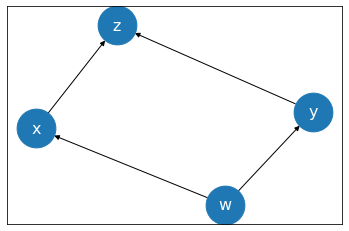

In [5]:
"""
Example: Synthetic Dataset

"""
graph = nx.DiGraph()
graph.add_nodes_from(['w', 'y', 'x', 'z'])
graph.add_edges_from([('w', 'x'), ('w', 'y'), ('x', 'z'), ('y', 'z')])
nx.draw_networkx(graph, node_size=1500, font_color='w', font_size=16)
plt.show()

# NCDA - Nonlinear Causal Discovery with Apriori

For further information about NCDA, click [here](https://github.com/marti5ini/GENCDA/blob/master/tutorials/ncda.ipynb)

In [17]:
# Instantiate main class
ncda = NCDApriori(data)
itemsets = ncda.fitApriori(target='m', zmax=3, nbins=4, strategy='quantile', support=5)
causal_relations = ncda.fitNCD(itemsets, alpha=0.001, sorting=np.max, train_size=0.7, standardization=True)

In [18]:
causal_relations

[('w', 'z'), ('y', 'z')]

# Synthetic data generation

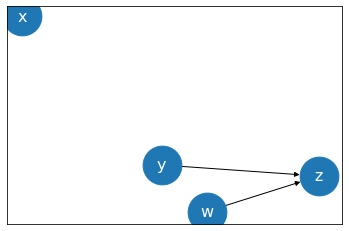

In [7]:
# Generate a DAG from causal relationships founded by NCDA
dag_ncda = nx.to_networkx_graph(causal_relations, create_using=nx.DiGraph)

# Add isolated nodes. We select them from dataset columns
dag_nodes = list(data.columns)
dag_ncda.add_nodes_from(dag_nodes)

nx.draw_networkx(dag_ncda, node_size=1500, font_color='w', font_size=16)
plt.show()

In [8]:
# Instantiate main class
generator = RelatedDataframe(data, dag_ncda)

# Generate new data based on ground truth dag 
gencda_data = generator.generate_data()

# Show new dataframe 
gencda_data.head()

,w,x,y,z
0,1.485864,21.418229,12.996386,-1.479276
1,3.844303,5.244329,16.629237,3.451354
2,-4.751987,2.774053,16.251829,-0.234688
3,4.424160,28.744473,14.945722,2.862477
4,2.832321,3.126939,16.042326,1.395770


# BASELINES

1# Baseline: **RANDOM GENERATION**

In [9]:
random_data = randomDataframe(data)

2# Baseline: **CTGAN**

In [10]:
"""
From Synthetic Data Vault Library (SDV)
https://sdv.dev/SDV/api_reference/tabular/api/sdv.tabular.ctgan.CTGAN.html

"""
# Instantiate main class
model = CTGAN()

# Fit CTGAN
model.fit(data)

# Save model
model.save(os.path.join(path, 'ctgan_model.pkl'))

# Generate new data
ctgan_data = model.sample(len(data))

# Save new dataframe 
ctgan_data.to_csv(os.path.join(path, 'ctgan_dataset.csv'), index=False)

3# Baseline: **TVAE**

In [11]:
"""
From SDV Library 
https://sdv.dev/SDV/api_reference/tabular/api/sdv.tabular.ctgan.TVAE.html

"""
# To apply tvae, the svd library requires columns names as strings 
if data.columns.dtype != 'str':
    data.columns = data.columns.astype(str)

# Instantiate main class
model = TVAE()

# Fit TVAE
model.fit(data)

# Save model
model.save(os.path.join(path, 'tvae_model.pkl'))

# Generate new data
tvae_data = model.sample(len(data))

# Save new dataframe 
tvae_data.to_csv(os.path.join(path, 'tvae_dataset.csv'), index=False)

# EVALUATION MEASURE

1) Compute SSE, RMSE using KERNEL DENSITY ESTIMATION

In [12]:
print(f'GENDATA {get_statistics(data, gencda_data)}')

print('\n')
print(f'RANDOM {get_statistics(data, random_data)}')

print('\n')
print(f'CTGAN {get_statistics(data, ctgan_data)}')

print('\n')
print(f'TVAE {get_statistics(data, tvae_data)}')


GENDATA {'rmse': {'mean': 0.0686963930683424}, 'sse': {'mean': 0.5670041574824952}}


RANDOM {'rmse': {'mean': 0.04617826420345373}, 'sse': {'mean': 0.21923868943681907}}


CTGAN {'rmse': {'mean': 0.04973430053029729}, 'sse': {'mean': 0.31229733869836684}}


TVAE {'rmse': {'mean': 0.02821356730413892}, 'sse': {'mean': 0.09298076841807186}}


2) Local Outlier Factor

In [13]:
print(f'GENDATA {lof(data, gencda_data, n_neighbors=50)}')

print('\n')
print(f'RANDOM {lof(data, random_data, n_neighbors=50)}')

print('\n')
print(f'CTGAN {lof(data, ctgan_data, n_neighbors=50)}')

print('\n')
print(f'TVAE {lof(data, tvae_data, n_neighbors=50)}')


GENDATA {'n_error_test': 973, 'stats': {'mean': -2.7651834583267365, 'max': 0.48398435031529563, 'min': -11.135403143644824, 'std': 1.7482293394214712, 'median': -2.5628407408217035}}


RANDOM {'n_error_test': 506, 'stats': {'mean': -0.11627719759349481, 'max': 0.5342738487070681, 'min': -1.7937867569105186, 'std': 0.5040380252101792, 'median': -0.0053398562701292285}}


CTGAN {'n_error_test': 429, 'stats': {'mean': -0.027896442631547627, 'max': 0.5361862523474601, 'min': -2.30814813611954, 'std': 0.44145895178507955, 'median': 0.07472412250793925}}


TVAE {'n_error_test': 80, 'stats': {'mean': 0.3411256383758135, 'max': 0.5425711344651915, 'min': -1.0710229098593906, 'std': 0.22670332375069863, 'median': 0.4254697235250604}}


# PLOT 

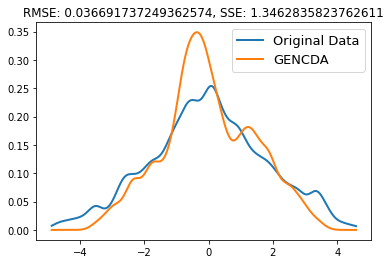

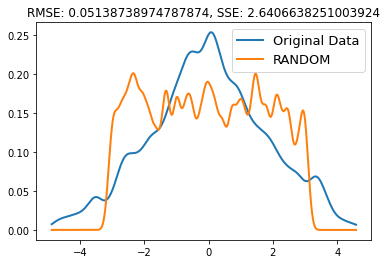

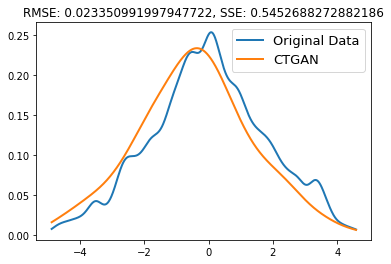

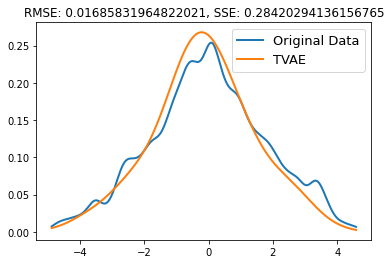

In [14]:
# Set index of column to plot
index = 3

datasets = [gencda_data, random_data, ctgan_data, tvae_data]
names = ['GENCDA', 'RANDOM', 'CTGAN', 'TVAE']

for dataset, name in zip(datasets, names):
    plotKDE(data.iloc[:, index], dataset.iloc[:, index], label1='Original Data', label2=name)
plt.show()